In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

sns.set_context("notebook")

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.colors as colors
#      "undef",  "shale",  "sltShale", "clnSand", "sltSand1", "sltSand2", "cemSand"
ccc = ['#B3B3B3','#996633', '#1B4F72', '#FFC82E','#FF7A36', '#DB0000', '#40CBFF']

In [19]:
from data_loading import well2_add_features
well1, well2, well3, well4, well5, well5_resist = well2_add_features()

In [22]:
well3 = well3[(well3.DEPTH > 2100) & (well3.DEPTH < 2300)]
well3.reset_index(inplace=True)

In [23]:
well3.head()

,index,DEPTH,VP,RHOB,GR
0,12467,2100.12085,2.32008,2.1995,61.5625
1,12468,2100.27319,2.24118,2.2300,60.1875
2,12469,2100.42554,2.16958,2.2194,55.0224
3,12470,2100.57788,2.28962,2.1974,49.4954
4,12471,2100.73047,2.31787,2.1926,46.6250


In [24]:
facies_labels = ["shale", "sltShale", "clnSand", "sltSand1", "sltSand2", "cemSand"]
facies = [1,2,3,4,5,6]
colors = ["black", "brown", "green", "purple", "orange", "magenta"]

conditions = [
    (well2["DEPTH"].ge(2078.0) & well2["DEPTH"].lt(2105.0)),
    (well2["DEPTH"].ge(2143.2) & well2["DEPTH"].lt(2154.1)),
    (well2["DEPTH"].ge(2154.1) & well2["DEPTH"].lt(2164.1)),
    (well2["DEPTH"].ge(2168.1) & well2["DEPTH"].lt(2184.1)),
    (well2["DEPTH"].ge(2186.1) & well2["DEPTH"].lt(2200.1)),
    (well2["DEPTH"].ge(2254.0) & well2["DEPTH"].lt(2300.1)),
]

well2["FACIES"] = np.select(conditions, facies)

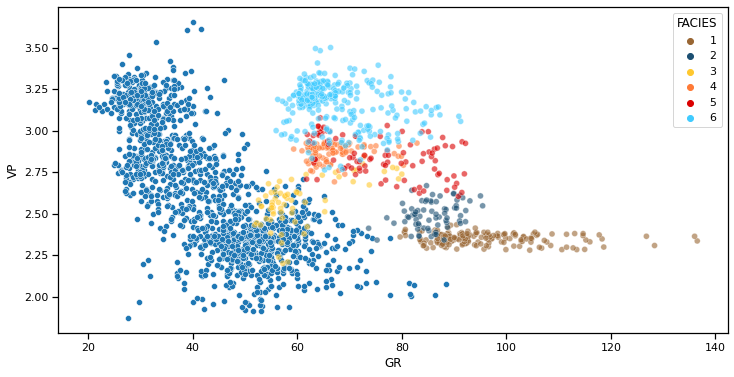

In [25]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=well3[(well3.DEPTH>2100) & (well3.DEPTH<2300)], x="GR", y="VP")
sns.scatterplot(data=well2[well2.FACIES!=0], x="GR", y="VP", hue='FACIES', palette=ccc[1:], alpha=0.6);

In [26]:
scaler = StandardScaler()
GR2 = np.array(well2.GR).reshape(-1, 1)
GR3 = np.array(well3.GR).reshape(-1, 1)
X2 = scaler.fit_transform(GR2)
X3 = scaler.fit_transform(GR3)

In [27]:
print(f"well2.GR: mean: {well2.GR.mean()}, stddev: {well2.GR.std()}")
print(f"normalised well2.GR: mean: {X2.mean()}, stddev: {X2.std()}")
print(f"well3.GR: mean: {well3.GR.mean()}, stddev: {well3.GR.std()}")
print(f"normalised well3.GR: mean: {X3.mean()}, stddev: {X3.std()}")

well2.GR: mean: 72.78512484818944, stddev: 14.464119835129793
normalised well2.GR: mean: -3.589819991209639e-16, stddev: 1.0
well3.GR: mean: 43.506763414634314, stddev: 11.892960745187802
normalised well3.GR: mean: 2.1662888285368908e-16, stddev: 1.0


In [28]:
import scipy.stats as ss

x3 = ss.zscore(X3) * well2.GR.std() + well2.GR.mean()
x3.mean(), x3.std()

(72.78512484818944, 14.464119835129795)

In [29]:
well2['GR_norm'] = X2
well3['GR_norm'] = X3
well3['GR_normW2'] = x3

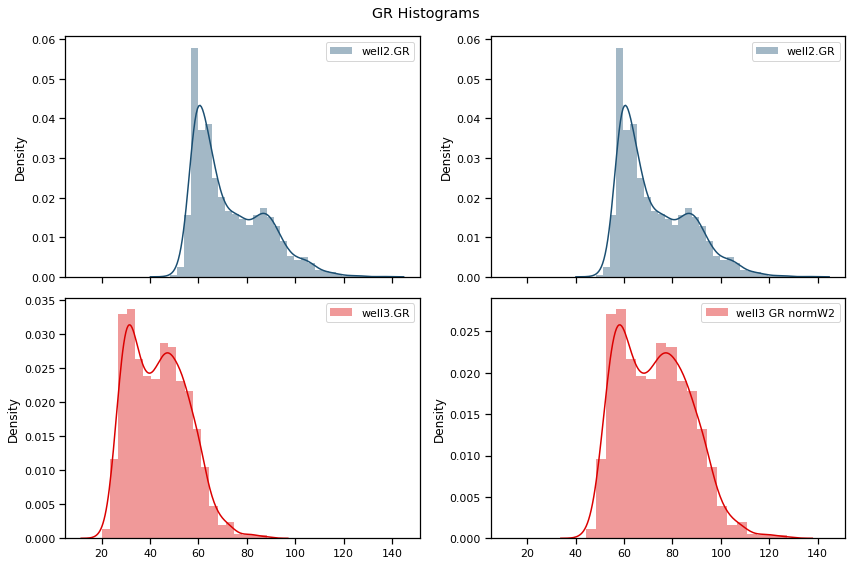

In [30]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(12,8))
fig.suptitle('GR Histograms')
sns.distplot(ax=ax1, x=well2.GR, color=ccc[2], label="well2.GR")
sns.distplot(ax=ax2, x=well2.GR, color=ccc[2], label="well2.GR")
sns.distplot(ax=ax3, x=well3.GR, color=ccc[5], label="well3.GR")
sns.distplot(ax=ax4, x=well3.GR_normW2, color=ccc[5], label="well3 GR normW2")

for ax in fig.get_axes():
    ax.legend()
    #ax.label_outer()
    
plt.tight_layout()

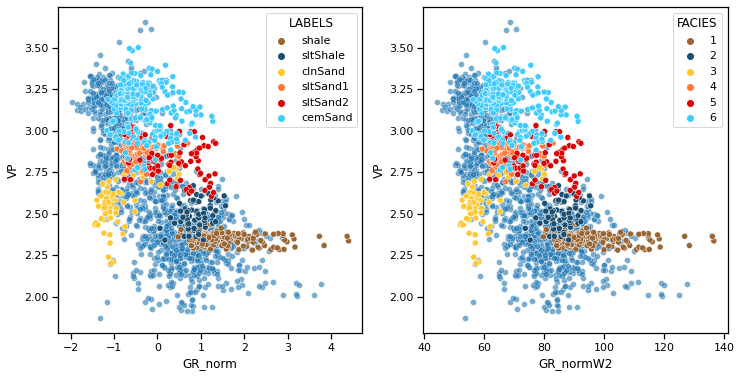

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
                               
sns.scatterplot(ax=ax1, data=well3, x="GR_norm", y="VP", alpha=0.6)
sns.scatterplot(ax=ax1, data=well2[well2.LABELS!='0'], x="GR_norm", y="VP", hue='LABELS', palette=ccc[1:])

sns.scatterplot(ax=ax2, data=well3, x="GR_normW2", y="VP", alpha=0.6)
sns.scatterplot(ax=ax2, data=well2[well2.FACIES!=0], x="GR", y="VP", hue='FACIES', palette=ccc[1:]);

In [32]:
train = well2[['VP', 'GR', 'FACIES']][well2['FACIES']!=0]

In [33]:
test = well3[(well3.DEPTH>2100) & (well3.DEPTH<2300)][['VP',  'GR_normW2']]

In [36]:
train.groupby('FACIES').count()

,VP,GR
FACIES,,
1,178,178
2,72,72
3,65,65
4,105,105
5,92,92
6,303,303


In [37]:
y = train.FACIES
X = train[['VP', 'GR']]

In [38]:
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline

In [ ]:
# Look at implementing pipeline...

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# pipe = make_pipeline(StandardScaler(), GaussianNB())
# pipe.fit(X_train, y_train)  # apply scaling on training data

# pipe.score(X_test, y_test)

In [ ]:
# #X = shuffle(X)  # !!! shuffle X,y together !!!

# # Standardise all X training/testing data
# scaler = StandardScaler().fit(X)
# X = scaler.transform(X)

# # create X_train, X_test from standarised X
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [ ]:
#print(f"X_train after X is standardised: \n{X_train[:5]}")
#print(f"X_test after X is standardised: \n{X_test[:5]}")

In [39]:
# create X_train, X_test from un-standarised X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
# Standardise X_train
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
# Standardise X_test from X_train
X_test = scaler.transform(X_test)

In [ ]:
#print(f"X_train after X is standardised: \n{X_train[:5]}")
#print(f"X_test after X is standardised: \n{X_test[:5]}")

In [ ]:
# naive Bayes

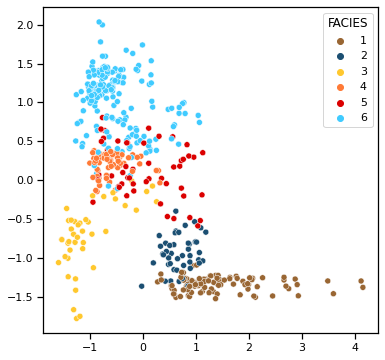

In [40]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=X_train, x=X_train[:,1], y=X_train[:,0], hue=y_train, palette=ccc[1:]);

In [41]:
model = GaussianNB()
model.fit(X_train, y_train);

[(-2.0, 2.0), (-3.0, 3.0)]

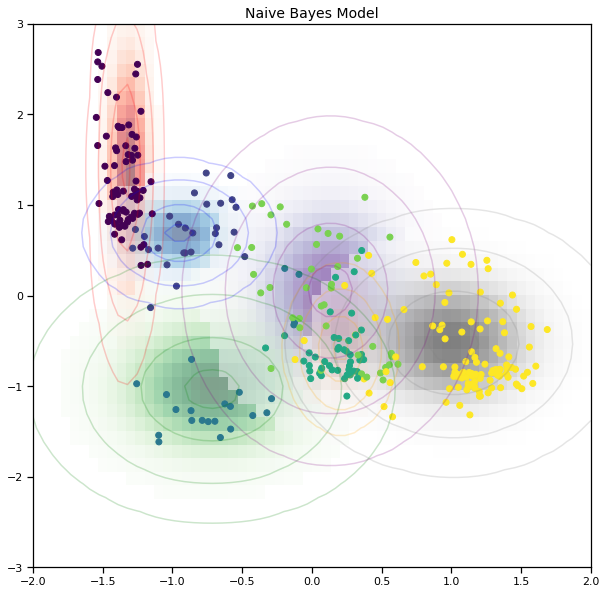

In [42]:
fig, ax = plt.subplots(figsize=(10,10))

# ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='rainbow', alpha=0.3)
ax.scatter(X_test[:,0], X_test[:,1], c=y_test)
ax.set_title('Naive Bayes Model', size=14)

xlim = (-2, 2)
ylim = (-3, 3)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(["red", "blue", "green", "orange", "purple", "grey"], start=1):  # facies (1->6)
    # X,y or X_train,y_train
    # mask = (y == label)
    # mu, std = X[mask].mean(0), X[mask].std(0)
    mask = (y_train == label)
    mu, std = X_train[mask].mean(0), X_train[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.2)
    
ax.set(xlim=xlim, ylim=ylim)

In [43]:
y_pred = model.predict(X_test)

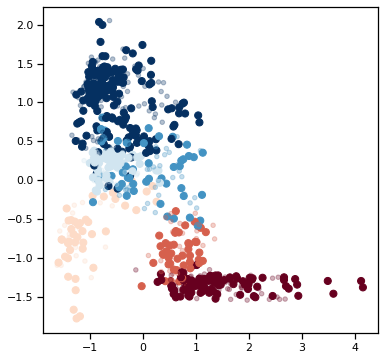

In [44]:
plt.figure(figsize=(6,6))
plt.scatter(X_train[:, 1], X_train[:, 0], c=y_train, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(X_test[:, 1], X_test[:, 0], c=y_pred, s=20, cmap='RdBu', alpha=0.3)
plt.axis(lim);

In [45]:
yprob = model.predict_proba(X_test)
# yprob[-20:].round(2)

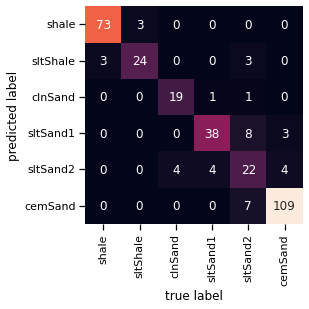

In [46]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, y_pred)  # true, pred, all
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=facies_labels, yticklabels=facies_labels)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
# confusion_matrix(y_test, y_pred, normalize='pred')  # normalises over COLS => Predictions

In [ ]:
# confusion_matrix(y_test, y_pred, normalize='true')  # normalises over ROWS => True

In [ ]:
# confusion_matrix(y_test, y_pred, normalize='all')  # normalises over ROWS and COLS

In [48]:
bootstrap_num = 500

In [49]:
for i in range(bootstrap_num):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if i == 0:
    
        bootstrap = confusion_matrix(y_test, y_pred, normalize='pred')  # normalises over COLS => Predictions
        
    else: bootstrap = np.append(bootstrap, confusion_matrix(y_test, y_pred, normalize='pred'))

In [50]:
bootstrap = bootstrap.reshape(bootstrap_num,6,6)

(0.1, 1.1)

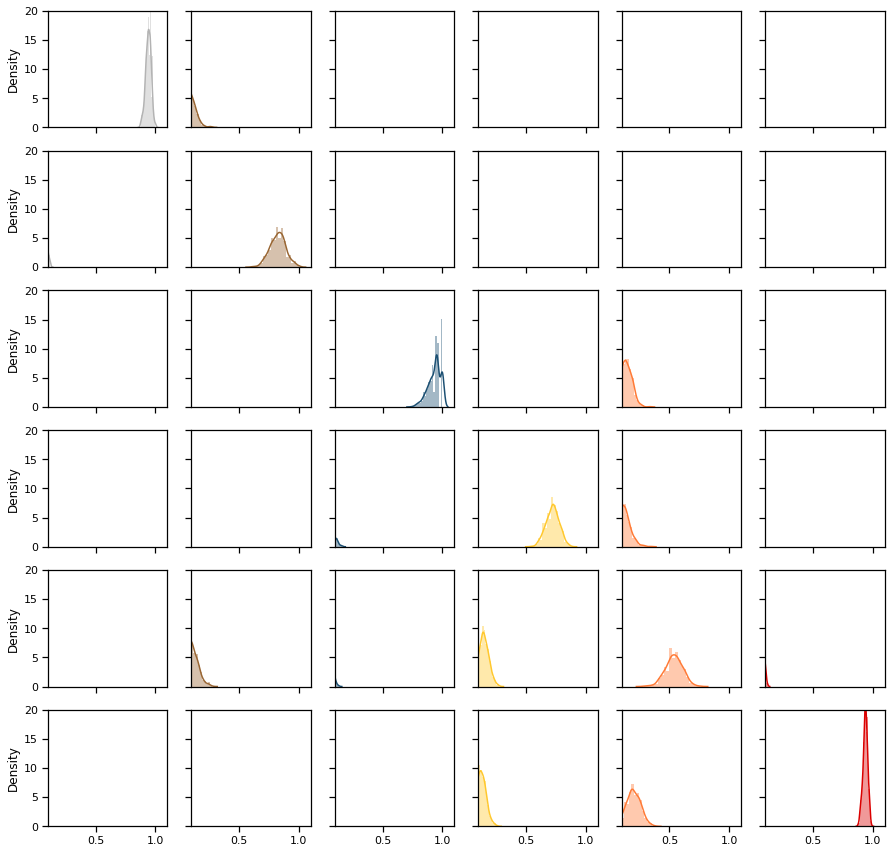

In [51]:
import seaborn as sns
fig, ((ax1,ax2,ax3,ax4,ax5,ax6),
      (ax7,ax8,ax9,ax10,ax11,ax12),
     (ax13,ax14,ax15,ax16,ax17,ax18),
     (ax19,ax20,ax21,ax22,ax23,ax24),
     (ax25,ax26,ax27,ax28,ax29,ax30),
     (ax31,ax32,ax33,ax34,ax35,ax36)) = plt.subplots(6, 6, sharex=True, sharey=True,figsize=(15,15))


sns.distplot(ax=ax1, x=bootstrap[:,0,0], color=ccc[0], label="shale-shale")
sns.distplot(ax=ax2, x=bootstrap[:,0,1], color=ccc[1], label="shale-shale")
sns.distplot(ax=ax3, x=bootstrap[:,0,2], color=ccc[2], label="shale-shale")
sns.distplot(ax=ax4, x=bootstrap[:,0,3], color=ccc[3], label="shale-shale")
sns.distplot(ax=ax5, x=bootstrap[:,0,4], color=ccc[4], label="shale-shale")
sns.distplot(ax=ax6, x=bootstrap[:,0,5], color=ccc[5], label="shale-shale")

sns.distplot(ax=ax7, x=bootstrap[:,1,0], color=ccc[0], label="shale-shale")
sns.distplot(ax=ax8, x=bootstrap[:,1,1], color=ccc[1], label="shale-shale")
sns.distplot(ax=ax9, x=bootstrap[:,1,2], color=ccc[2], label="shale-shale")
sns.distplot(ax=ax10, x=bootstrap[:,1,3], color=ccc[3], label="shale-shale")
sns.distplot(ax=ax11, x=bootstrap[:,1,4], color=ccc[4], label="shale-shale")
sns.distplot(ax=ax12, x=bootstrap[:,1,5], color=ccc[5], label="shale-shale")

sns.distplot(ax=ax13, x=bootstrap[:,2,0], color=ccc[0], label="shale-shale")
sns.distplot(ax=ax14, x=bootstrap[:,2,1], color=ccc[1], label="shale-shale")
sns.distplot(ax=ax15, x=bootstrap[:,2,2], color=ccc[2], label="shale-shale")
sns.distplot(ax=ax16, x=bootstrap[:,2,3], color=ccc[3], label="shale-shale")
sns.distplot(ax=ax17, x=bootstrap[:,2,4], color=ccc[4], label="shale-shale")
sns.distplot(ax=ax18, x=bootstrap[:,2,5], color=ccc[5], label="shale-shale")

sns.distplot(ax=ax19, x=bootstrap[:,3,0], color=ccc[0], label="shale-shale")
sns.distplot(ax=ax20, x=bootstrap[:,3,1], color=ccc[1], label="shale-shale")
sns.distplot(ax=ax21, x=bootstrap[:,3,2], color=ccc[2], label="shale-shale")
sns.distplot(ax=ax22, x=bootstrap[:,3,3], color=ccc[3], label="shale-shale")
sns.distplot(ax=ax23, x=bootstrap[:,3,4], color=ccc[4], label="shale-shale")
sns.distplot(ax=ax24, x=bootstrap[:,3,5], color=ccc[5], label="shale-shale")

sns.distplot(ax=ax25, x=bootstrap[:,4,0], color=ccc[0], label="shale-shale")
sns.distplot(ax=ax26, x=bootstrap[:,4,1], color=ccc[1], label="shale-shale")
sns.distplot(ax=ax27, x=bootstrap[:,4,2], color=ccc[2], label="shale-shale")
sns.distplot(ax=ax28, x=bootstrap[:,4,3], color=ccc[3], label="shale-shale")
sns.distplot(ax=ax29, x=bootstrap[:,4,4], color=ccc[4], label="shale-shale")
sns.distplot(ax=ax30, x=bootstrap[:,4,5], color=ccc[5], label="shale-shale")

sns.distplot(ax=ax31, x=bootstrap[:,5,0], color=ccc[0], label="shale-shale")
sns.distplot(ax=ax32, x=bootstrap[:,5,1], color=ccc[1], label="shale-shale")
sns.distplot(ax=ax33, x=bootstrap[:,5,2], color=ccc[2], label="shale-shale")
sns.distplot(ax=ax34, x=bootstrap[:,5,3], color=ccc[3], label="shale-shale")
sns.distplot(ax=ax35, x=bootstrap[:,5,4], color=ccc[4], label="shale-shale")
sns.distplot(ax=ax36, x=bootstrap[:,5,5], color=ccc[5], label="shale-shale")

plt.ylim(0,20)
plt.xlim(0.1,1.1)

In [52]:
X_well3 = np.array(well3[['VP', 'GR_normW2']])
X_well3 = scaler.transform(X_well3)

In [53]:
y_pred_well3 = model.predict(X_well3)

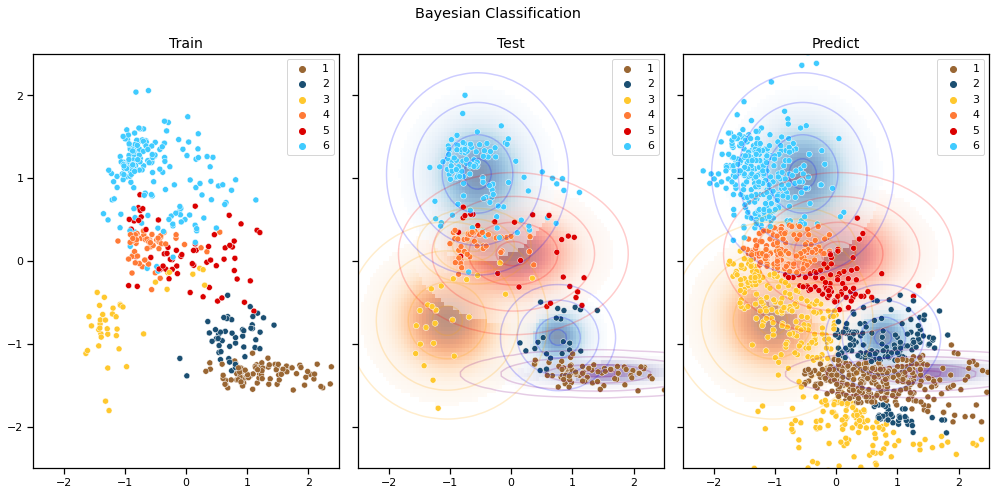

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(14,7))
fig.suptitle('Bayesian Classification')

sns.scatterplot(ax=ax1, data=X_train, x=X_train[:,1], y=X_train[:,0], hue=y_train, palette=ccc[1:])
ax1.set_title('Train', size=14)

sns.scatterplot(ax=ax2, x=X_test[:,1], y=X_test[:,0], hue=y_test, palette=ccc[1:])
ax2.set_title('Test', size=14)

# will only work with equal x,y limits: haven't worked out how colours / contours work together
xlim = (-2.5, 2.5)
ylim = (-2.5, 2.5)

# Transposed the axes to fit with x: GR, y:Vp
xg = np.linspace(xlim[0], xlim[1], 100)  #60, yg works
yg = np.linspace(ylim[0], ylim[1], 100)  #40, xg works
yy, xx = np.meshgrid(xg, yg) # swapped xx, yy
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

#for label, color in enumerate(["red", "blue", "green", "orange", "purple", "grey"], start=1):
for label, color in enumerate(["purple", "blue", "orange", "orange", "red", "blue"], start=1):

    mask = (y_train == label)
    mu, std = X_train[mask].mean(0), X_train[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)  # Product of normals ??
    Pm = np.ma.masked_array(P, P < 0.03)  # 0.03, affects "influence" of each pdf ???
    ax2.pcolorfast(yg, xg, Pm.reshape(yy.shape), alpha=0.5, cmap=color.title() + 's')
    ax2.contour(yy, xx, P.reshape(xx.shape), levels=[0.01, 0.1, 0.5, 0.9], colors=color, alpha=0.2)
    ax3.pcolorfast(yg, xg, Pm.reshape(yy.shape), alpha=0.5, cmap=color.title() + 's')
    ax3.contour(yy, xx, P.reshape(xx.shape), levels=[0.01, 0.1, 0.5, 0.9], colors=color, alpha=0.2)
    
ax2.set(xlim=xlim, ylim=ylim)

sns.scatterplot(ax=ax3, data=X_well3, x=X_well3[:,1], y=X_well3[:,0], hue=y_pred_well3, palette=ccc[1:]);
ax3.set_title("Predict", size=14)
for ax in fig.get_axes():
    ax.legend()
    #ax.label_outer()
    
plt.tight_layout()

In [55]:
# model.predict_proba(X_well3).round(2)[:20]

In [56]:
well3['FACIES_p'] = y_pred_well3

In [63]:
import xarray as xr
#!pip install sklearn_xarray
from sklearn_xarray import wrap

from sklearn.pipeline import make_pipeline, make_union
from packages.sklearn_xarray import Stacker, Select

In [58]:
# load X_well3 n times to simulate xarray seismic volume

In [59]:
vp3 = np.random.random(1312)*well3.VP.std() + well3.VP.mean() # well3.VP
gr3 = np.random.random(1312)*well3.GR.std() + well3.GR.mean() # well3.GR

for i in range(399):
    vp3 = np.append(vp3, np.random.random(1312)*well3.VP.std() + well3.VP.mean())
    gr3 = np.append(gr3, np.random.random(1312)*well3.GR.std() + well3.GR.mean())
    
vp3 = vp3.reshape(20,20,1312)
gr3 = gr3.reshape(20,20,1312)

In [60]:
# ds is in a seismic volume arrangement
ds = xr.Dataset(
    data_vars = {
        "Vp": (("il", "xl", "twt"), vp3),
        "GR": (("il", "xl", "twt"), gr3),
    },
    coords={
        "il":np.arange(101,101+vp3.shape[0],1),
        "xl":np.arange(1,1+vp3.shape[0],1),
        "twt":np.arange(0,5248,4),
        },
)

In [61]:
ds

<xarray.Dataset>
Dimensions:  (il: 20, xl: 20, twt: 1312)
Coordinates:
  * il       (il) int32 101 102 103 104 105 106 107 ... 115 116 117 118 119 120
  * xl       (xl) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
  * twt      (twt) int32 0 4 8 12 16 20 24 ... 5224 5228 5232 5236 5240 5244
Data variables:
    Vp       (il, xl, twt) float64 2.924 2.736 2.64 2.773 ... 2.929 2.845 2.821
    GR       (il, xl, twt) float64 44.17 47.24 51.82 44.74 ... 49.72 45.68 44.21

In [122]:
ds[['Vp', 'GR']].to_array().stack(z=('il','xl','twt'))

<xarray.DataArray (variable: 2, z: 524800)>
array([[ 2.92405699,  2.736191  ,  2.64008847, ...,  2.92900333,
         2.84458469,  2.82145212],
       [44.1699794 , 47.24212392, 51.81502623, ..., 49.72059375,
        45.68065033, 44.21380913]])
Coordinates:
  * variable  (variable) <U2 'Vp' 'GR'
  * z         (z) MultiIndex
  - il        (z) int64 101 101 101 101 101 101 101 ... 120 120 120 120 120 120
  - xl        (z) int64 1 1 1 1 1 1 1 1 1 1 1 ... 20 20 20 20 20 20 20 20 20 20
  - twt       (z) int64 0 4 8 12 16 20 24 ... 5220 5224 5228 5232 5236 5240 5244

In [124]:
flat_ds = ds.to_array().stack(z=('il','xl','twt'))

In [129]:
flat_ds_t = flat_ds.transpose('z', 'variable')
flat_ds_t

<xarray.DataArray (z: 524800, variable: 2)>
array([[ 2.92405699, 44.1699794 ],
       [ 2.736191  , 47.24212392],
       [ 2.64008847, 51.81502623],
       ...,
       [ 2.92900333, 49.72059375],
       [ 2.84458469, 45.68065033],
       [ 2.82145212, 44.21380913]])
Coordinates:
  * variable  (variable) <U2 'Vp' 'GR'
  * z         (z) MultiIndex
  - il        (z) int64 101 101 101 101 101 101 101 ... 120 120 120 120 120 120
  - xl        (z) int64 1 1 1 1 1 1 1 1 1 1 1 ... 20 20 20 20 20 20 20 20 20 20
  - twt       (z) int64 0 4 8 12 16 20 24 ... 5220 5224 5228 5232 5236 5240 5244

In [133]:
y_p = model.predict(flat_ds_t)
y_p.shape

(524800,)

In [134]:
y_p

array([5, 1, 1, ..., 1, 5, 5])

In [135]:
template = flat_ds_t[:,0]
output_array = template.copy(data=y_p)
output_array

<xarray.DataArray (z: 524800)>
array([5, 1, 1, ..., 1, 5, 5])
Coordinates:
    variable  <U2 'Vp'
  * z         (z) MultiIndex
  - il        (z) int64 101 101 101 101 101 101 101 ... 120 120 120 120 120 120
  - xl        (z) int64 1 1 1 1 1 1 1 1 1 1 1 ... 20 20 20 20 20 20 20 20 20 20
  - twt       (z) int64 0 4 8 12 16 20 24 ... 5220 5224 5228 5232 5236 5240 5244

In [136]:
unstacked = output_array.unstack()
unstacked

<xarray.DataArray (il: 20, xl: 20, twt: 1312)>
array([[[5, 1, 1, ..., 1, 1, 1],
        [1, 5, 5, ..., 1, 5, 1],
        [5, 1, 5, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 5, 1, 1],
        [1, 5, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 5, 1]],

       [[1, 1, 1, ..., 5, 1, 1],
        [5, 1, 5, ..., 1, 5, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 5, 1, ..., 1, 1, 1]],

       [[1, 5, 1, ..., 1, 1, 5],
        [1, 1, 1, ..., 1, 5, 5],
        [5, 1, 1, ..., 1, 5, 5],
        ...,
...
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 5, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [5, 1, 1, ..., 1, 1, 1],
        [1, 5, 1, ..., 5, 5, 5],
        [1, 1, 1, ..., 1, 1, 1]],

       [[5, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 5, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [5, 1, 1, ..., 1, 1, 1],
        [5, 1, 5, ..., 1, 5, 5]]])
Coordinates:
    variable  <U2 'Vp'
  * il        (il) int64 101 102 103 104 105 106 107 ... 115 116 117 118 119 120
  * xl        (xl) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
  * twt       (twt) int64 0 4 8 12 16 20 24 ... 5224 5228 5232 5236 5240 5244

In [137]:
print(ds[['Vp', 'GR']].to_stacked_array("z", sample_dims=["il", "twt", "xl"]).shape)
print(ds[['Vp', 'GR']].to_stacked_array("z", sample_dims=["il", "twt"]).shape)
print(ds[['Vp', 'GR']].to_stacked_array("z", sample_dims=["twt"]).shape)
print(ds[['Vp', 'GR']].to_stacked_array("z", sample_dims=["il"]).shape)
print(ds[['Vp', 'GR']].to_stacked_array("z", sample_dims=["il", "xl"]).shape)
print(ds[['Vp', 'GR']].to_stacked_array("z", sample_dims=[]).shape)
# ds[['Vp', 'GR']].to_stacked_array("z", sample_dims=[])

(20, 20, 1312, 2)
(20, 1312, 40)
(1312, 800)
(20, 52480)
(20, 20, 2624)
(1049600,)


In [138]:
# simulate random velocity (1 vertical log) data using VP mean and std
vp3 = np.random.random(1312)*well3.VP.std() + well3.VP.mean() # well3.VP
# simulate random gamma ray data using GR mean and std
gr3 = np.random.random(1312)*well3.GR.std() + well3.GR.mean() # well3.GR

# create enough (400) for a small 3D cube of data
for i in range(399):
    vp3 = np.append(vp3, np.random.random(1312)*well3.VP.std() + well3.VP.mean())
    gr3 = np.append(gr3, np.random.random(1312)*well3.GR.std() + well3.GR.mean())
    
# Reshape data into 3D cube
vp3 = vp3.reshape(20,20,1312)
gr3 = gr3.reshape(20,20,1312)

# Create inline, crossline and twt-way-time coords
vp3_xr = xr.DataArray(vp3,
                      dims=('il', 'xl', 'twt'),
                      name='well3',
                      coords={
                          "il":np.arange(101,101+vp3.shape[0],1), 
                          "xl":np.arange(1,1+vp3.shape[0],1), 
                          "twt":np.arange(0,5248,4)
                              },
                      )

gr3_xr = xr.DataArray(gr3,
                      dims=('il', 'xl', 'twt'),
                      name='well3',
                      coords={
                          "il":np.arange(101,101+vp3.shape[0],1), 
                          "xl":np.arange(1,1+vp3.shape[0],1), 
                          "twt":np.arange(0,5248,4)
                              },
                      )

In [139]:
# Save to dataset
xr3_ds = vp3_xr.to_dataset(name = 'Vp')
xr3_ds['GR'] = gr3_xr

In [140]:
xr3_ds
xr3_ds.isel(il=10, xl=10)  # xr3_ds[{'il':10, 'xl':10}]
xr3_ds.isel(twt=800)  # xr3_ds[{'twt':800}]
xr3_ds['Vp'].isel(twt=800)  # xr3_ds['Vp'][:,:,800]
xr3_ds.isel(il=slice(None, 2), xl=slice(17, None))

<xarray.Dataset>
Dimensions:  (il: 2, xl: 3, twt: 1312)
Coordinates:
  * il       (il) int32 101 102
  * xl       (xl) int32 18 19 20
  * twt      (twt) int32 0 4 8 12 16 20 24 ... 5224 5228 5232 5236 5240 5244
Data variables:
    Vp       (il, xl, twt) float64 2.757 2.834 2.645 2.664 ... 2.738 2.907 2.772
    GR       (il, xl, twt) float64 51.82 47.41 51.63 51.67 ... 55.29 53.15 44.64

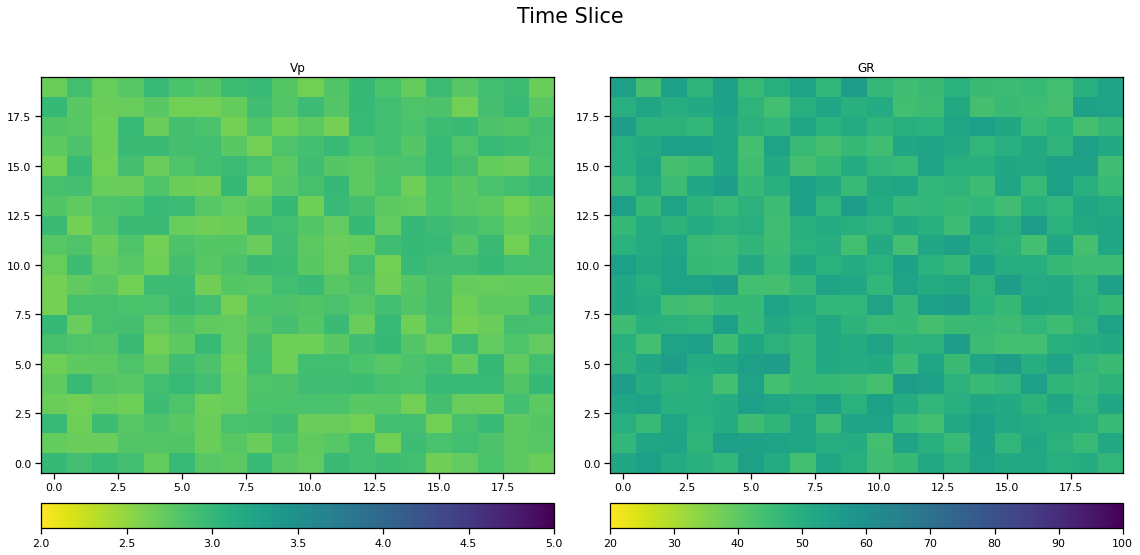

In [141]:
fig, axs = plt.subplots(1,2, figsize = (16,8))

# Define the map extent and common plotting parameters
#extent = [xlines[0], xlines[-1], ilines[0], ilines[-1]]
plt_kwargs = {'cmap':'viridis_r', 'origin':'lower', 'aspect':'auto'}#, 'extent':extent}

# Plot Vp "twt" slice
#im1=axs[0].imshow(xr3_ds['Vp'][:,:,800], **plt_kwargs, vmin=2, vmax=5)
im1=axs[0].imshow(xr3_ds['Vp'].isel(twt=800), **plt_kwargs, vmin=2, vmax=5)
axs[0].set_title('Vp')
fig.colorbar(im1, ax=axs[0], orientation='horizontal', pad=0.06)

# Plot GR "twt" slice
im2=axs[1].imshow(xr3_ds['GR'].isel(twt=800), **plt_kwargs, vmin=20, vmax=100)
axs[1].set_title('GR')
fig.colorbar(im2, ax=axs[1], orientation='horizontal', pad=0.06)

# Add a title to the figure
fig.suptitle('Time Slice', size='xx-large', va='bottom')
plt.tight_layout()
plt.show()

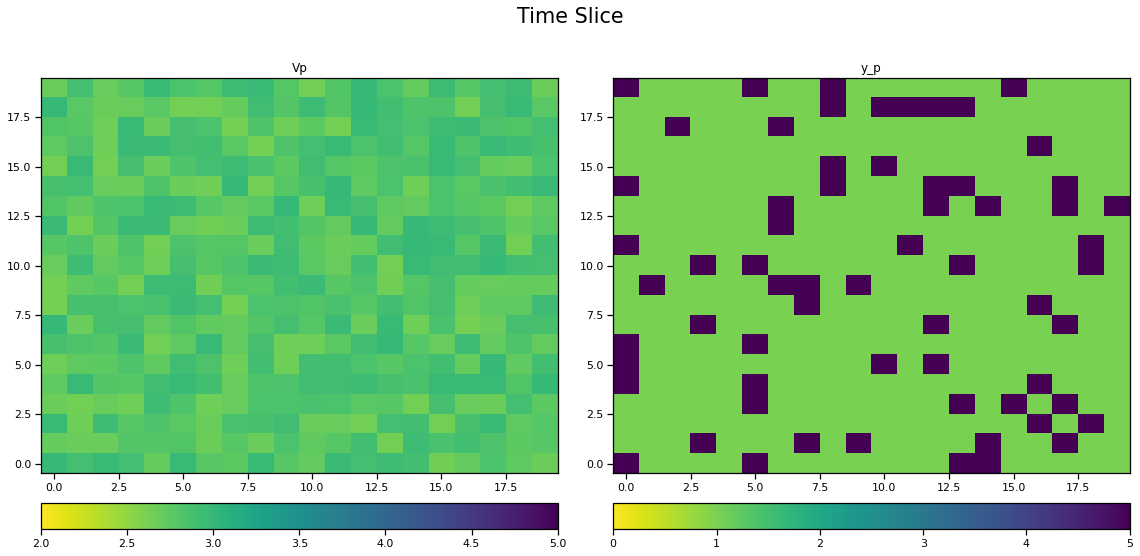

In [143]:
fig, axs = plt.subplots(1,2, figsize = (16,8))

# Define the map extent and common plotting parameters
#extent = [xlines[0], xlines[-1], ilines[0], ilines[-1]]
plt_kwargs = {'cmap':'viridis_r', 'origin':'lower', 'aspect':'auto'}#, 'extent':extent}

# Plot Vp "twt" slice
#im1=axs[0].imshow(xr3_ds['Vp'][:,:,800], **plt_kwargs, vmin=2, vmax=5)
im1=axs[0].imshow(xr3_ds['Vp'].isel(twt=800), **plt_kwargs, vmin=2, vmax=5)
axs[0].set_title('Vp')
fig.colorbar(im1, ax=axs[0], orientation='horizontal', pad=0.06)

# Plot y_p "twt" slice
im2=axs[1].imshow(unstacked.isel(twt=800), **plt_kwargs, vmin=0, vmax=5)
axs[1].set_title('y_p')
fig.colorbar(im2, ax=axs[1], orientation='horizontal', pad=0.06)

# Add a title to the figure
fig.suptitle('Time Slice', size='xx-large', va='bottom')
plt.tight_layout()
plt.show()

In [ ]:
def make_model(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))
    #print("Feature importances:\n{}".format(model.feature_importances_))
    predictions = model.predict(X_test)
    conf = confusion_matrix(y_test, predictions)
    #print(display_cm(conf, facies, hide_zeros=True))
    print(confusion_matrix(y_test, predictions))
    #print(score(y_test.values, predictions))


In [ ]:
model = RandomForestClassifier(random_state=0)
make_model(model, X_train, y_train, X_test, y_test)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [ ]:
model = GradientBoostingClassifier()
make_model(model, X_train, y_train, X_test, y_test)

In [ ]:
model = AdaBoostClassifier()
make_model(model, X_train, y_train, X_test, y_test)

In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=6)
# make_model(model, train, train_labels, val, val_labels)
make_model(model, X_train, y_train, X_test, y_test)

In [ ]:
vp3.shape

da = xr.DataArray(
    vp3,
    dims=(
        'il','xl','twt'
    ),
    coords = {
        'il': np.arange(20),
        'xl': np.arange(20),
        'twt': np.arange(1312),
    }
)

da



# ds is in a seismic volume arrangement
ds = xr.Dataset(
    data_vars = {
        "Vp": (("il", "xl", "twt"), vp3),
        "GR": (("il", "xl", "twt"), gr3),
    },
    coords={
        "il":np.arange(101,101+vp3.shape[0],1),
        "xl":np.arange(1,1+vp3.shape[0],1),
        "twt":np.arange(0,5248,4),
        },
)

flat_ds = ds.stack(z=('il', 'xl'))

flat_ds

flattened_da = da.stack(z=('il', 'xl', 'twt'))
flattened_da

flattened_ds = ds.stack(z=('il', 'xl', 'twt'))
flattened_ds  # AttributeError: 'Dataset' object has no attribute 'shape'

flattened_ds.shape

flattened_ds_T = flattened_ds.transpose('z', 'twt')
flattened_ds_T.shape

flattened_ds_T

Xt = wrap(StandardScaler()).fit_transform(flattened_ds)
type(Xt)

Xt = wrap(StandardScaler()).fit_transform(flattened_ds_T)
Xt

wrapper = wrap(GaussianNB())
model = wrapper.fit(X_train, y_train)

flat_ds.isel(twt=0)['Vp']
flat_ds['Vp']

model.predict(flattened_ds)